# Quantum Gate calibration using Model Free Reinforcement Learning

We extend the state preparation scheme to a gate calibration scheme by providing multiple input states to the target.

In [1]:
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)
from quantumenvironment import QuantumEnvironment
from helper_functions import select_optimizer, generate_model

# Qiskit imports for building RL environment (circuit level)
from qiskit import IBMQ
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit.extensions import CXGate, XGate
from qiskit.opflow import Zero, One, Plus, Minus, H, I, X, CX, S, Z
from qiskit_ibm_runtime import QiskitRuntimeService

# Tensorflow imports for building RL agent and framework
import tensorflow as tf
from tensorflow_probability.python.distributions import MultivariateNormalDiag

from tf_agents.specs import array_spec, tensor_spec

# Additional imports
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

In [2]:
# IBMQ.save_account(TOKEN)
IBMQ.load_account()  # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [3]:
# Ansatz function, could be at pulse level or circuit level
def apply_parametrized_circuit(qc: QuantumCircuit):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    :param qc: Quantum Circuit instance to add the gates on
    :return:
    """
    # qc.num_qubits
    global n_actions
    params = ParameterVector('theta', n_actions)
    qc.u(2 * np.pi * params[0], 2 * np.pi * params[1], 2 * np.pi * params[2], 0)
    # qc.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], 0)
    qc.u(2 * np.pi * params[3], 2 * np.pi * params[4], 2 * np.pi * params[5], 1)
    qc.rzx(2 * np.pi * params[6], 0, 1)

Below, we set the RL environment parameters, that is how we describe our quantum system. Below, we choose to go through the use of Qiskit Runtime, and use a simulator to get measurement outcomes based on the ansatz circuit defined above. The Environment is defined as a class object called QuantumEnvironment.

In [4]:
service = QiskitRuntimeService(channel='ibm_quantum')
seed = 3590  # Seed for action sampling
backend = service.backends(simulator=True)[0]  # Simulation backend (mock quantum computer)
options = {"seed_simulator": None, 'resilience_level': 0}
print('backend for quantum system:', backend)
n_qubits = 2
sampling_Paulis = 100
N_shots = 1  # Number of shots for sampling the quantum computer for each action vector

n_actions = 7  # Choose how many control parameters in pulse/circuit parametrization
time_steps = 1  # Number of time steps within an episode (1 means you do one readout and assign right away the reward)
action_spec = tensor_spec.BoundedTensorSpec(shape=(n_actions,), dtype=tf.float32, minimum=-1., maximum=1.)
observation_spec = array_spec.ArraySpec(shape=(time_steps,), dtype=np.int32)

Qiskit_setup = {
    "backend": backend,
    "service": service,
    "parametrized_circuit": apply_parametrized_circuit,
    "options": options
}

backend for quantum system: <IBMBackend('ibmq_qasm_simulator')>


In [5]:
# Target gate: CNOT gate

circuit_Plus_i = S @ H
circuit_Minus_i = S @ H @ X
cnot_target = {
    "target_type": "gate",
    "gate": CXGate("CNOT"),
    "input_states": [{"name": "|00>",  # Drawn from Ref [21] of PhysRevLett.93.080502
                      "circuit": I ^ 2,
                      "register": [0, 1]
                      },
                     {"name": "|01>",
                      "circuit": X ^ I,
                      "register": [0, 1]
                      },
                     {"name": "|10>",
                      "circuit": I ^ X,
                      "register": [0, 1]
                      },
                     {"name": "|11>",
                      "circuit": X ^ X,
                      "register": [0, 1]
                      },
                     {"name": "|+_1>",
                      "circuit": X ^ H,
                      "register": [0, 1]
                      },
                     {"name": "|0_->",
                      "circuit": (H @ X) ^ I,
                      "register": [0, 1]
                      },
                     {"name": "|+_->",
                      "circuit": (H @ X) ^ H,
                      "register": [0, 1]
                      },
                     {"name": "|1_->",
                      "circuit": (H @ X) ^ X,
                      "register": [0, 1]
                      },
                     {"name": "|+_0>",
                      "circuit": I ^ H,
                      "register": [0, 1]
                      },
                     {"name": "|0_->",
                      "circuit": (H @ X) ^ I,
                      "register": [0, 1]
                      },
                     {"name": "|i_0>",
                      "circuit": I ^ circuit_Plus_i,
                      "register": [0, 1]
                      },
                     {"name": "|i_1>",
                      "circuit": X ^ circuit_Plus_i,
                      "register": [0, 1]
                      },
                     {"name": "|0_i>",
                      "circuit": circuit_Plus_i ^ I,
                      "register": [0, 1]
                      },
                     {"name": "|i_i>",
                      "circuit": circuit_Plus_i ^ circuit_Plus_i,
                      "register": [0, 1]
                      },
                     {"name": "|i_->",
                      "circuit": (H @ X) ^ circuit_Plus_i,
                      "register": [0, 1]
                      },
                     {"name": "|+_i->",
                      "circuit": circuit_Minus_i ^ H,
                      "register": [0, 1]
                      }

                     ]
}


In [6]:
# Define quantum environment

q_env = QuantumEnvironment(n_qubits=n_qubits, target=cnot_target, abstraction_level="circuit",
                           action_spec=action_spec, observation_spec=observation_spec,
                           Qiskit_config=Qiskit_setup,
                           sampling_Pauli_space=sampling_Paulis, n_shots=N_shots, c_factor=1.)

In [7]:
# Hyperparameters for the agent
n_epochs = 10000  # Number of epochs
batchsize = 300  # Batch size (iterate over a bunch of actions per policy to estimate expected return)
opti = "Adam"
eta = 0.0018  # Learning rate for policy update step
eta_2 = None  # Learning rate for critic (value function) update step

use_PPO = True
epsilon = 0.1  # Parameter for clipping value (PPO)
grad_clip = 0.01
critic_loss_coeff = 0.5
optimizer = select_optimizer(lr=eta, optimizer=opti, grad_clip=grad_clip, concurrent_optimization=True, lr2=eta_2)
sigma_eps = 1e-3  # for numerical stability

In [8]:
# Policy parameters
N_in = n_qubits + 1  # One input for each measured qubit state (0 or 1 input for each neuron)
hidden_units = [20, 20, 30]  # List containing number of units in each hidden layer

network = generate_model((N_in,), hidden_units, n_actions, actor_critic_together=True)
network.summary()
init_msmt = np.zeros((1, N_in))  # Here no feedback involved, so measurement sequence is always the same

2023-02-07 16:13:25.821580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 20)           80          input_1[0][0]                    
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 20)           420         hidden_0[0][0]                   
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 30)           630         hidden_1[0][0]                   
______________________________________________________________________________________________

In [9]:
# Plotting tools
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
avg_return = np.zeros(n_epochs)
fidelities = np.zeros(n_epochs)
visualization_steps = 20
%matplotlib inline

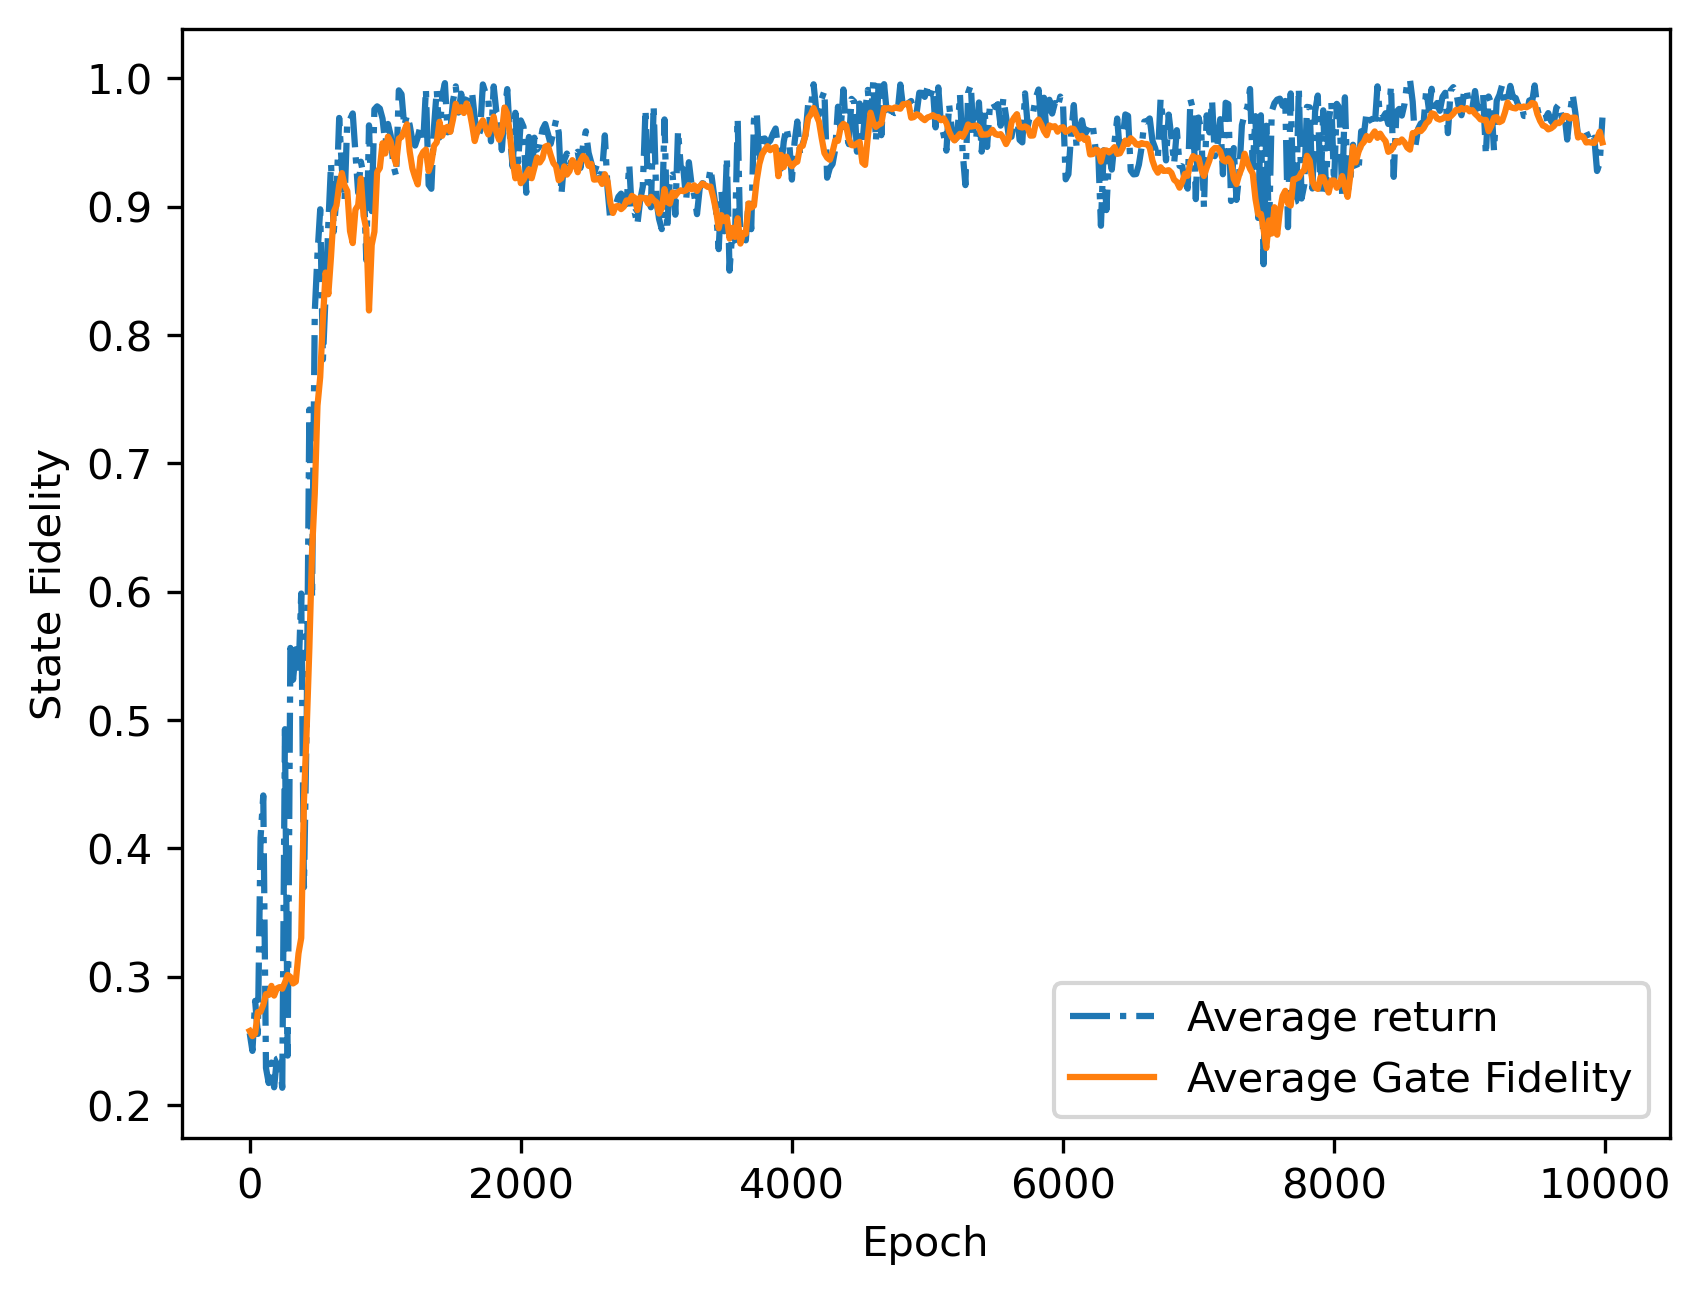

100%|███████████████████████████████████▉| 9981/10000 [8:49:16<00:51,  2.71s/it]

Maximum fidelity reached so far: 0.9835198860343602


100%|███████████████████████████████████▉| 9982/10000 [8:49:19<00:47,  2.66s/it]

Gate Fidelity 0.9508183608241811


100%|███████████████████████████████████▉| 9983/10000 [8:49:21<00:44,  2.63s/it]

Gate Fidelity 0.9501107313472155


100%|███████████████████████████████████▉| 9984/10000 [8:49:24<00:41,  2.57s/it]

Gate Fidelity 0.950822717160965


100%|███████████████████████████████████▉| 9985/10000 [8:49:27<00:39,  2.64s/it]

Gate Fidelity 0.9518527906890142


100%|███████████████████████████████████▉| 9986/10000 [8:49:30<00:38,  2.78s/it]

Gate Fidelity 0.9521036350326544


100%|███████████████████████████████████▉| 9987/10000 [8:49:33<00:37,  2.86s/it]

Gate Fidelity 0.9511258465781723


100%|███████████████████████████████████▉| 9988/10000 [8:49:36<00:34,  2.88s/it]

Gate Fidelity 0.9521539756858848


100%|███████████████████████████████████▉| 9989/10000 [8:49:39<00:32,  2.98s/it]

Gate Fidelity 0.9491310298055167


100%|███████████████████████████████████▉| 9990/10000 [8:49:42<00:30,  3.02s/it]

Gate Fidelity 0.9498346520784176


100%|███████████████████████████████████▉| 9991/10000 [8:49:45<00:27,  3.04s/it]

Gate Fidelity 0.947421136858389


100%|███████████████████████████████████▉| 9992/10000 [8:49:48<00:24,  3.02s/it]

Gate Fidelity 0.9482359725701518


100%|███████████████████████████████████▉| 9993/10000 [8:49:51<00:20,  3.00s/it]

Gate Fidelity 0.9457874698515536


100%|███████████████████████████████████▉| 9994/10000 [8:49:54<00:17,  2.97s/it]

Gate Fidelity 0.9477435909716388


100%|███████████████████████████████████▉| 9995/10000 [8:49:57<00:14,  2.91s/it]

Gate Fidelity 0.9460153379034235


100%|███████████████████████████████████▉| 9996/10000 [8:49:59<00:11,  2.86s/it]

Gate Fidelity 0.9472217452993359


100%|███████████████████████████████████▉| 9997/10000 [8:50:02<00:08,  2.77s/it]

Gate Fidelity 0.9460401245884494


100%|███████████████████████████████████▉| 9998/10000 [8:50:05<00:05,  2.74s/it]

Gate Fidelity 0.9469466225584475


100%|███████████████████████████████████▉| 9999/10000 [8:50:08<00:02,  2.78s/it]

Gate Fidelity 0.944790443627853


100%|███████████████████████████████████| 10000/10000 [8:50:10<00:00,  3.18s/it]

Gate Fidelity 0.9457095435301413


In [10]:
"""
-----------------------------------------------------------------------------------------------------
Training loop
-----------------------------------------------------------------------------------------------------
"""
# TODO: Use TF-Agents PPO Agent
mu_old = tf.Variable(initial_value=network(init_msmt)[0][0], trainable=False)
sigma_old = tf.Variable(initial_value=network(init_msmt)[1][0], trainable=False)

policy_params_str = 'Policy params:'
print('Neural net output', network(init_msmt), type(network(init_msmt)))
print("mu_old", mu_old)
print("sigma_old", sigma_old)

for i in tqdm(range(n_epochs)):

    Old_distrib = MultivariateNormalDiag(loc=mu_old, scale_diag=sigma_old,
                                         validate_args=True, allow_nan_stats=False)

    with tf.GradientTape(persistent=True) as tape:

        mu, sigma, b = network(init_msmt, training=True)
        mu = tf.squeeze(mu, axis=0)
        sigma = tf.squeeze(sigma, axis=0)
        b = tf.squeeze(b, axis=0)

        Policy_distrib = MultivariateNormalDiag(loc=mu, scale_diag=sigma,
                                                validate_args=True, allow_nan_stats=False)

        action_vector = tf.stop_gradient(tf.clip_by_value(Policy_distrib.sample(batchsize), -1., 1.))

        reward = q_env.perform_action_gate_cal(action_vector)
        advantage = reward - b

        if use_PPO:
            ratio = Policy_distrib.prob(action_vector) / (tf.stop_gradient(Old_distrib.prob(action_vector)) + 1e-6)
            actor_loss = - tf.reduce_mean(tf.minimum(advantage * ratio,
                                                     advantage * tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)))
        else:  # REINFORCE algorithm
            actor_loss = - tf.reduce_mean(advantage * Policy_distrib.log_prob(action_vector))

        critic_loss = tf.reduce_mean(advantage ** 2)
        combined_loss = actor_loss + critic_loss_coeff * critic_loss

    grads = tape.gradient(combined_loss, network.trainable_variables)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.assign(mu)
        sigma_old.assign(sigma)

    avg_return[i] = np.mean(q_env.reward_history, axis =1)[i]
    fidelities[i] = q_env.avg_fidelity_history[i]
    print("Gate Fidelity", fidelities[i])
    if i%visualization_steps == 0:
        clear_output(wait=True) # for animation
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, n_epochs, 20),avg_return[0:-1:visualization_steps], '-.', label='Average return')
        ax.plot(np.arange(1, n_epochs, 20),fidelities[0:-1:visualization_steps], label='Average Gate Fidelity')
        ax.set_xlabel("Epoch")
        ax.set_ylabel("State Fidelity")
        ax.legend()
        plt.show()
        print("Maximum fidelity reached so far:", np.max(fidelities))

    # Apply gradients
    optimizer.apply_gradients(zip(grads, network.trainable_variables))


In [11]:
print("Maximum fidelity reached:", np.max(fidelities), 'at Epoch ', np.argmax(fidelities))

Maximum fidelity reached: 0.9835198860343602 at Epoch  9470


In [14]:
np.save("average_gate_fidelity_CNOT", fidelities)

In [15]:
np.save("average_return_CNOT", avg_return)

In [16]:
np.save("epoch_list", np.arange(1, n_epochs, 20))

In [17]:
np.save("avg_process_fidelity", q_env.process_fidelity_history)